<a href="https://colab.research.google.com/github/zecakpm/Regression_analysis/blob/main/RegressionAnalisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install -q seaborn

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [6]:
# make numpy printous easier to read
np.set_printoptions(precision=3, suppress=True)



In [7]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [10]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year','Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [11]:
df = raw_dataset.copy()
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [12]:
df.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [14]:
df = df.dropna()

In [16]:
df['Origin'] = df['Origin'].map({1: 'USA',2:'Europe',3:'Japan'})
df = pd.get_dummies(df, columns=['Origin'], prefix='', prefix_sep='')
df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [17]:
train_df = df.sample(frac=0.8,random_state=0)
test_df = df.drop(train_df.index)

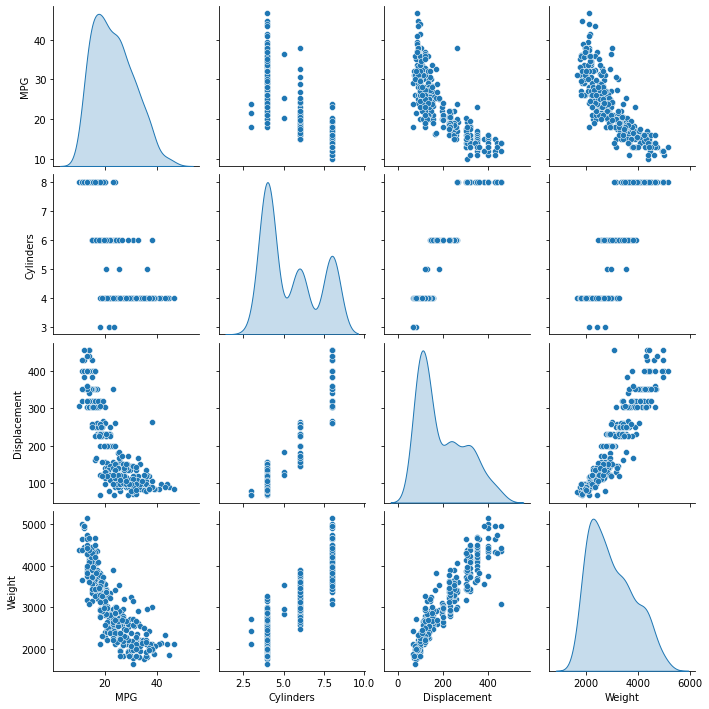

In [20]:
sns.pairplot(train_df[['MPG','Cylinders','Displacement','Weight']], diag_kind='kde')

In [21]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [23]:
train_features = train_df.copy()
test_features = test_df.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')


In [24]:
train_df.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [25]:
normalizer = preprocessing.Normalization()

In [26]:
normalizer.adapt(np.array(train_features))

In [27]:
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


In [29]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [33]:
hp = np.array(train_features['Horsepower'])

hp_normalizer = preprocessing.Normalization(input_shape=[1,])
hp_normalizer.adapt(hp)

In [35]:
hp_model = tf.keras.Sequential([
                               hp_normalizer,
                               layers.Dense(units=1)
])

hp_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [36]:
hp_model.predict(hp[:10])

array([[ 0.508],
       [ 0.287],
       [-0.937],
       [ 0.712],
       [ 0.644],
       [ 0.253],
       [ 0.763],
       [ 0.644],
       [ 0.168],
       [ 0.287]], dtype=float32)

In [38]:
hp_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [41]:
%%time
history = hp_model.fit(
    train_features['Horsepower'], train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2
)

CPU times: user 8.46 s, sys: 198 ms, total: 8.66 s
Wall time: 8.51 s


In [42]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.801779,4.191746,95
96,3.803432,4.183646,96
97,3.805785,4.213390,97
98,3.807896,4.186577,98
99,3.814896,4.218331,99


In [44]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0,10])
  plt.xlabel('Epoch')
  plt.ylabel('Error[MPG]')
  plt.legend()
  plt.grid(True)
  

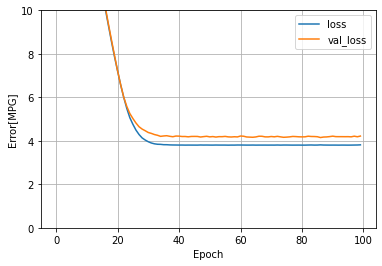

In [45]:
plot_loss(history)

In [47]:
test_results = {}
test_results['hp_model'] = hp_model.evaluate(
    test_features['Horsepower'],
    test_labels, verbose=0
)

In [48]:
x = tf.linspace(0.0,250,251)
y = hp_model.predict(x)

In [49]:
def plot_hp(x,y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x,y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

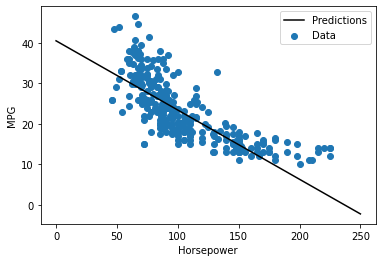

In [50]:
plot_hp(x,y)

In [54]:
ln_model = tf.keras.Sequential([normalizer,
                                layers.Dense(units=1)])

In [56]:
ln_model.predict(train_features[:10])

array([[ 2.311],
       [ 0.378],
       [ 0.526],
       [ 0.596],
       [-1.471],
       [-0.147],
       [-1.508],
       [-3.289],
       [ 0.962],
       [-0.256]], dtype=float32)

In [57]:
ln_model.layers[1].kernel

<tf.Variable 'dense_2/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.189],
       [-0.464],
       [ 0.029],
       [-0.293],
       [-0.448],
       [-0.737],
       [-0.599],
       [-0.382],
       [ 0.49 ]], dtype=float32)>

In [60]:
ln_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [61]:
%%time
history = ln_model.fit(
    train_features, train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2
)

CPU times: user 8.42 s, sys: 176 ms, total: 8.6 s
Wall time: 8.32 s


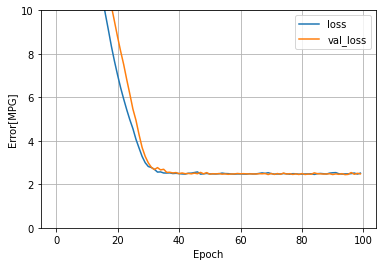

In [62]:
plot_loss(history)

In [87]:
test_results['linear_model'] = ln_model.evaluate(
    test_features, test_labels, verbose=0
)

In [65]:
def build_and_compile_model(norm):
  model= keras.Sequential([
                           norm,
                           layers.Dense(64, activation='relu'),
                           layers.Dense(64, activation='relu'),
                           layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [66]:
dnn_hp_model = build_and_compile_model(hp_normalizer)

In [67]:
dnn_hp_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [71]:
%%time
history = dnn_hp_model.fit(
    train_features['Horsepower'],train_labels,
    validation_split=0.2,
    verbose=0, epochs=100
)

CPU times: user 8.76 s, sys: 211 ms, total: 8.98 s
Wall time: 8.62 s


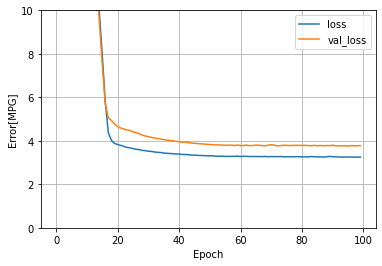

In [72]:
plot_loss(history)

In [73]:
x = tf.linspace(0.0, 250,251)
y = dnn_hp_model.predict(x)

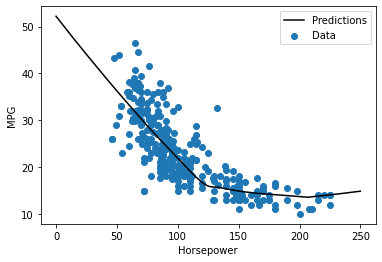

In [75]:
plot_hp(x,y)

In [76]:
test_results['dnn_hp_model'] = dnn_hp_model.evaluate(
    test_features['Horsepower'],test_labels,
    verbose=0
)

In [77]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_9 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [78]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100
)

CPU times: user 9.18 s, sys: 217 ms, total: 9.4 s
Wall time: 9 s


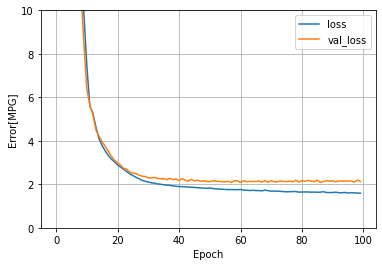

In [79]:
plot_loss(history)

In [80]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [88]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
hp_model,3.638436
dnn_hp_model,2.935197
dnn_model,1.759989
linear_model,2.450837


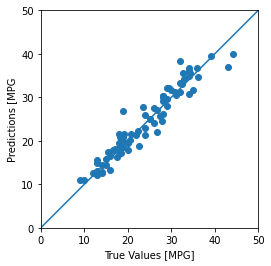

In [89]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

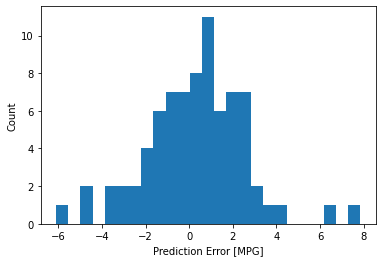

In [90]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

In [91]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


In [93]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels,verbose=0)

In [96]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
hp_model,3.638436
dnn_hp_model,2.935197
dnn_model,1.759989
linear_model,2.450837
reloaded,1.759989
